<a href="https://colab.research.google.com/github/shearere2/fall_2024_transit/blob/main/OneLineLinProg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DEA

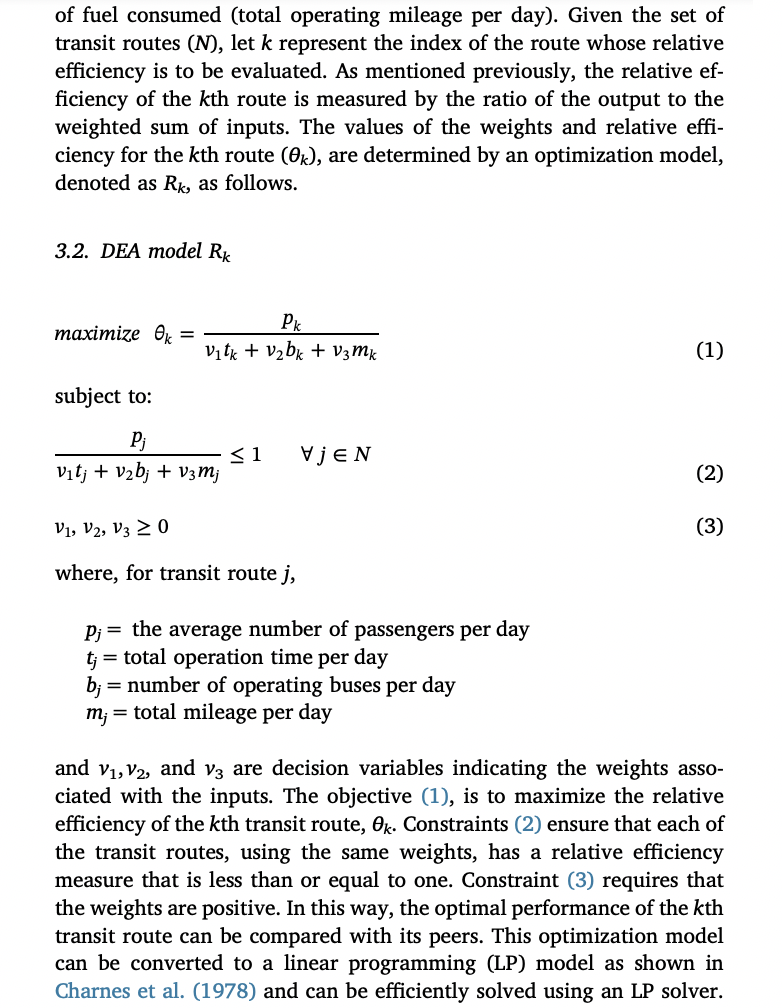

In [22]:
import pandas as pd

In [23]:
performance = pd.read_csv('on_time_performance.csv')

In [24]:
performance.sort_values(by='on_time_percent')

,_id,route,ridership_route_code,route_full_name,current_garage,mode,month_start,year_month,day_type,on_time_percent,data_source
7910,7951,O1,O1,O1 - ROSS FLYER,Ross,Bus,2019-11-01,201911,SAT.,0.0000,Clever
7335,7336,P17,P17,P17 - LINCOLN PARK FLYER,East Liberty,Bus,2019-09-01,201909,SUN.,0.0000,Clever
8685,8816,52L,052L,52L - HOMEVILLE LIMITED,West Mifflin,Bus,2020-02-01,202002,SUN.,0.0000,Clever
9721,9899,60,60,60 - MCKEESPORT - WALNUT,West Mifflin,Bus,2020-05-01,202005,SUN.,0.0000,NaN
7337,7338,P2,P2,P2 - EAST BUSWAY SHORT,East Liberty,Bus,2019-09-01,201909,SAT.,0.0000,Clever
...,...,...,...,...,...,...,...,...,...,...,...
13061,13473,18,NaN,18 - MANCHESTER,Ross,Bus,2021-07-01,202107,WEEKDAY,0.9773,Clever
21517,22614,RLSH,NaN,RLSH - Red Line Shuttle,South Hills Village,Light Rail,2024-06-01,202406,SUN.,0.9775,Clever
6823,6824,18,018,18 - MANCHESTER,Ross,Bus,2019-08-01,201908,WEEKDAY,0.9781,Clever
21761,22868,RLSH,NaN,RLSH - Red Line Shuttle,South Hills Village,Light Rail,2024-07-01,202407,SUN.,0.9871,Clever


In [25]:
# Used for DEA (data envelopment analysis)
ridership = pd.read_csv('ridership_by_route.csv')
avg_daily_riders = ridership.groupby('route')['avg_riders'].mean().sort_values(ascending=False).reset_index()
# Average daily riders per route

In [26]:
schedule = pd.read_csv('schedule_daily_agg.csv')
# Schedule is daily sum statistics

avg_total_mileage_per_day = schedule.groupby('RouteCode')['Trp.Dist.'].mean().sort_values(ascending=False).reset_index()
# (Per route)

avg_total_operation_mins_per_day = schedule.groupby('RouteCode')['Trip_Mins'].mean().sort_values(ascending=False).reset_index()
# (Per route)

<ipython-input-26-7a294da7a8c2>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  schedule = pd.read_csv('schedule_daily_agg.csv')


In [27]:
# Vechiles per route estimate
avg_operating_vehicles_per_day = pd.read_csv('vehicles_per_route_estimates.csv')

In [28]:
avg_daily_riders.rename(columns={'route': 'Route'}, inplace=True)
avg_total_mileage_per_day.rename(columns={'RouteCode': 'Route'}, inplace=True)
avg_total_operation_mins_per_day.rename(columns={'RouteCode':'Route'}, inplace=True)
avg_operating_vehicles_per_day

route_data = pd.merge(avg_daily_riders, avg_total_mileage_per_day, on='Route')
route_data = pd.merge(route_data, avg_total_operation_mins_per_day, on='Route')
route_data = pd.merge(route_data, avg_operating_vehicles_per_day, on='Route')
route_data
# Can be used for DEA (data envelopment analysis) equation

,Route,avg_riders,Trp.Dist.,Trip_Mins,num_vehicles,date
0,51,4322.717709,2036.443480,9298.488304,10,9/10/24
1,P1,4291.754104,2064.216867,5244.998886,6,9/10/24
2,61C,3640.686502,1749.228830,7508.332519,13,9/10/24
3,71C,2803.775683,1016.992340,5963.064380,6,9/10/24
4,61D,2760.259982,1211.048141,6174.668772,6,9/10/24
...,...,...,...,...,...,...
88,P13,164.619806,214.033188,677.402984,0,9/10/24
89,7,99.570395,81.513667,381.069873,0,9/10/24
90,O5,69.514755,119.975072,359.992405,2,9/10/24
91,18,66.221918,83.681609,373.930090,1,9/10/24


In [29]:
A_ub = []
b_ub = []
for index, row in route_data.iterrows():
  A_ub.append([-row['Trip_Mins'], -row['num_vehicles'], -row['Trp.Dist.']])
  b_ub.append(-row['avg_riders'])

In [30]:
from scipy.optimize import linprog

results = []

v1_bounds = (0, None)
v2_bounds = (0, None)
v3_bounds = (0, None)
bounds = [v1_bounds, v2_bounds, v3_bounds]

for index, row in route_data.iterrows():

  p_k = row['avg_riders']
  t_k = row['Trip_Mins']
  b_k = row['num_vehicles']
  m_k = row['Trp.Dist.']

  result = linprog(c=[t_k/p_k, b_k/p_k, m_k/p_k], A_ub=A_ub, b_ub=b_ub, bounds=bounds)
  results.append(1 - result.fun/p_k) # Efficiency

In [31]:
route_data['operational_efficiency'] = results